## Named Entity Recognition using LSTM + CRF

In this notebook we train a (LSTM + CRF) model for Named Entity Recognition on a Kaggle dataset and evaluate its performance.

Dataset from Kaggle: https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv("data/ner_dataset.csv", encoding="latin1")

In [3]:
data = data.fillna(method="ffill")

In [4]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [5]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

35179

In [6]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

In [7]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(data)

In [9]:
sent = getter.get_next()

In [10]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [11]:
sentences = getter.sentences

### Prepare the data

Now we introduce dictionaries of words and tags.

In [12]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [13]:
word2idx["Obama"]

8487

In [14]:
tag2idx["B-geo"]

6

Now we map the senctences to a sequence of numbers and then pad the sequence. Note that we increased the index of the words by one to use zero as a padding value. This is done because we want to use the mask_zero parameter of the embedding layer to ignore inputs with value zero.

In [15]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.


In [16]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

In [17]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [18]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

For training the network we also need to change the labels y to categorial.

In [19]:
from keras.utils import to_categorical

In [20]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

### Setup the CRF-LSTM

Now we can fit a LSTM-CRF network with an embedding layer.

In [23]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

In [24]:
input = Input(shape=(max_len,))

model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer

out = crf(model)  # output

In [25]:
model = Model(input, out)

In [26]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 17)            1190      
Total params: 738,240
Trainable params: 738,240
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 332s 9ms/step - loss: 8.9268 - acc: 0.9033 - val_loss: 8.6875 - val_acc: 0.9494
Epoch 2/5
38846/38846 [==============================] - 319s 8ms/step - loss: 8.7028 - acc: 0.9588 - val_loss: 8.6396 - val_acc: 0.9609
Epoch 3/5
38846/38846 [==============================] - 340s 9ms/step - loss: 8.6744 - acc: 0.9669 - val_loss: 8.6262 - val_acc: 0.9644
Epoch 4/5
38846/38846 [==============================] - 341s 9ms/step - loss: 8.6638 - acc: 0.9700 - val_loss: 8.6235 - val_acc: 0.9651
Epoch 5/5
38846/38846 [==============================] - 319s 8ms/step - loss: 8.6580 - acc: 0.9722 - val_loss: 8.6185 - val_acc: 0.9665


In [30]:
hist = pd.DataFrame(history.history)
print(hist.head())

   val_loss   val_acc      loss       acc
0  8.687474  0.949398  8.926819  0.903327
1  8.639563  0.960927  8.702759  0.958762
2  8.626178  0.964447  8.674406  0.966905
3  8.623462  0.965074  8.663831  0.970042
4  8.618545  0.966534  8.657970  0.972215


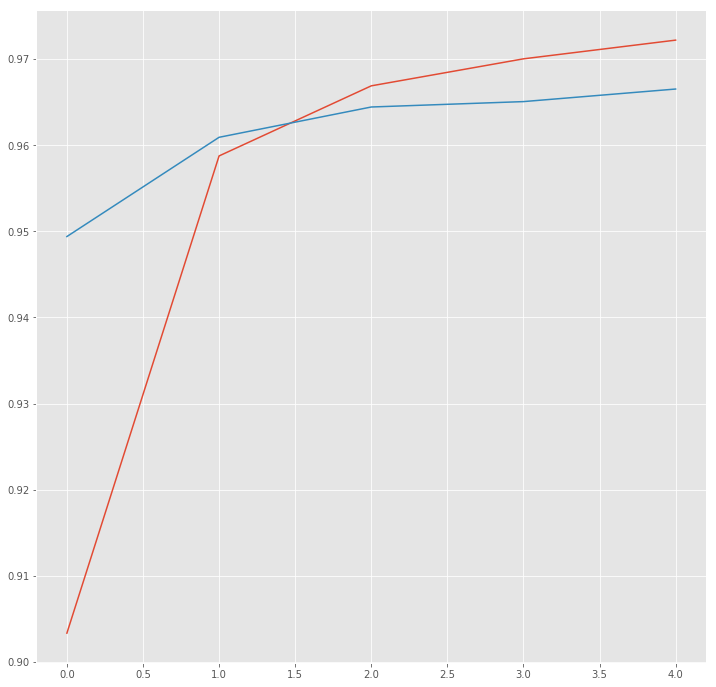

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [32]:
i = 1927
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
Last           : O     O
August         : B-tim B-tim
,              : O     O
Mr.            : B-per B-per
Ma             : I-per I-per
was            : O     O
cleared        : O     O
of             : O     O
corruption     : O     O
charges        : O     O
filed          : O     O
against        : O     O
him            : O     O
.              : O     O


### Using New Data

In [33]:
test_sentence = ["Hawking", "was", "a", "Fellow", "of", "the", "Royal", "Society", ",", "a", "lifetime", "member",
                 "of", "the", "Pontifical", "Academy", "of", "Sciences", ",", "and", "a", "recipient", "of",
                 "the", "Presidential", "Medal", "of", "Freedom", ",", "the", "highest", "civilian", "award",
                 "in", "the", "United", "States", "."]

In [34]:
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)

In [35]:
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))

Word           ||Prediction
Hawking        : I-nat
was            : O    
a              : O    
Fellow         : O    
of             : O    
the            : O    
Royal          : B-org
Society        : I-org
,              : O    
a              : O    
lifetime       : O    
member         : O    
of             : O    
the            : O    
Pontifical     : B-org
Academy        : I-org
of             : I-org
Sciences       : I-org
,              : O    
and            : O    
a              : O    
recipient      : O    
of             : O    
the            : O    
Presidential   : O    
Medal          : I-nat
of             : O    
Freedom        : B-geo
,              : O    
the            : O    
highest        : O    
civilian       : O    
award          : O    
in             : O    
the            : O    
United         : B-geo
States         : I-geo
.              : O    


### References

1. Huang et. al: Bidirectional LSTM-CRF Models for Sequence Tagging [https://arxiv.org/pdf/1508.01991v1.pdf]
2. Ma et al.: End-to-end Sequence Labeling via Bi-directional LSTM-CNNs-CRF [https://arxiv.org/pdf/1603.01354.pdf]